In [12]:
# 忽略警告訊息
import warnings
warnings.filterwarnings("ignore")

# 模型擬合、評估與超參數調校

## 一般實作流程

目標：以寶可夢的數值型特徵預測是否擁有雙屬性
- 新增一個hasType2欄位，標明是否有雙屬性

In [1]:
import pandas as pd

# 讀取資料
df = pd.read_csv('ex4.csv')

# 動態建立欄位 hasType2，若 Type2 欄位不是 NaN 則填入 1，否則填入 0
df['hasType2'] = df['Type2'].notnull().astype(int)

# 計算雙屬性的數量
print('雙屬性的數量：', df['hasType2'].sum())

# 計算單屬性的數量
print('單屬性的數量：', df.shape[0]-df['hasType2'].sum())

# 顯示最後 3 筆資料
df.tail(3)

雙屬性的數量： 473
單屬性的數量： 421


,Number,Name,Type1,Type2,HP,Attack,Defense,SpecialAtk,SpecialDef,Speed,Generation,Legendary,hasType2
891,805,壘磊石,Rock,Steel,61,131,211,53,101,13,7,False,1
892,806,砰頭小丑,Fire,Ghost,53,127,53,151,79,107,7,False,1
893,807,捷拉奧拉,Electric,NaN,88,112,75,102,80,143,7,False,0


依下列轉換步驟進行，再以邏輯斯迴歸建模預測是否有雙屬性。
1. 切割訓練與測試集，其中測試集佔20%。
2. 挑選數值特徵與目標項間ANOVA的F值最高前兩名。

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif

# 準備訓練資料
X, y = df.loc[:, 'HP':'Speed'], df['hasType2']

# 顯示欄位名稱
print(X.columns)

# 切分訓練與測試資料
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=0
)

# 依 ANOVA F-Value 挑選前兩名的特徵
select = SelectKBest(f_classif, k=2)
select = select.fit(X_train, y_train)

# 顯示挑選的特徵
print(select.get_support())

# 顯示挑選的特徵名稱
print('挑出的特徵：', X.columns[select.get_support()])

# 顯示挑選的特徵分數
X_train_new = select.transform(X_train)

# 顯示資料筆數和特徵數
X_train_new.shape

Index(['HP', 'Attack', 'Defense', 'SpecialAtk', 'SpecialDef', 'Speed'], dtype='object')
[False False  True  True False False]
挑出的特徵： Index(['Defense', 'SpecialAtk'], dtype='object')


(715, 2)

3. 對挑選出來的特徵進行標準化

In [4]:
from sklearn.preprocessing import StandardScaler

# 建立標準化物件
scaler = StandardScaler()
scaler = scaler.fit(X_train_new)

# 對挑選出來的特徵，進行標準化
X_train_std = scaler.transform(X_train_new)

# 取得測試資料的特徵
X_test_new = select.transform(X_test)

# 對挑選出來的特徵，進行標準化
X_test_std = scaler.transform(X_test_new)

# 顯示標準化後的資料
X_test_std[:3, :]

array([[0.86655534, 1.47194431],
       [1.03103292, 2.85717958],
       [1.03103292, 0.67158616]])

4. 利用邏輯斯迴歸建模，並對測試集進行測試，最後輸出準確率。

In [5]:
from sklearn.linear_model import LogisticRegression

# 建立羅吉斯迴歸模型
logit = LogisticRegression(penalty='l2')

# 訓練模型
logit.fit(X_train_std, y_train)

# 顯示訓練資料的準確度
logit.score(X_test_std, y_test)

0.6480446927374302

經過上述在前處理階段的特徵挑選、轉換與邏輯斯迴歸建模，最終得到準確率為0.64。  
接著，底下利用管道化方式將挑選、轉換與建模整合成一條龍作業。

## 管道化

In [6]:
from sklearn.pipeline import Pipeline

# 建立管線，其中包含特徵選擇、標準化與羅吉斯迴歸
pipe_lr = Pipeline([
    ('selK', SelectKBest(f_classif, k=2)),
    ('sc', StandardScaler()),
    ('clf', LogisticRegression(penalty='l2'))
])

# 訓練模型
pipe_lr.fit(X_train, y_train)

# 顯示測試資料的準確度
pipe_lr.score(X_test, y_test)

0.6480446927374302

In [7]:
from sklearn import set_config

# 設定顯示方式
set_config(display='diagram')

# 顯示管線
pipe_lr

Pipeline(steps=[('selK', SelectKBest(k=2)), ('sc', StandardScaler()),
                ('clf', LogisticRegression())])

採用不同處理方式或是整合多種類型特徵的轉換步驟
1. 加入類別型特徵 Generation 的獨熱編碼
2. 從中挑選與目標項卡方值最高的前三名做為特徵
3. 與前面挑選出來的數值型特徵一併透過邏輯斯迴歸來建模

In [10]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import chi2
from sklearn.compose import ColumnTransformer

# 處理數值型特徵
num_features = X.columns
num_transform = Pipeline([
    ('selK', SelectKBest(f_classif, k=2)), 
    ('sc', StandardScaler())
])

# 處理類別型特徵
cat_features = ['Generation']
cat_transform = Pipeline([
    ('onehot', OneHotEncoder()), 
    ('selK', SelectKBest(chi2, k=3))
])

# 整合兩個處理步驟
pre = ColumnTransformer( 
    transformers=[
        ('num', num_transform, num_features), # 意思是對 num_features 進行 num_transform 處理
        ('cat', cat_transform, cat_features) # 意思是對 cat_features 進行 cat_transform 處理
    ]
)

# 管道化
pipe = Pipeline([
    ('preprocessor', pre),
    ('clf', LogisticRegression(penalty='l2'))
])

# 準備訓練資料
X, y = df.loc[:, 'HP':'Generation'], df['hasType2']

# 切分訓練與測試資料
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# 訓練模型
pipe.fit(X_train, y_train)

# 顯示測試資料的準確度
pipe.score(X_test, y_test)

0.6256983240223464

In [11]:
# 檢視管線
pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('selK',
                                                                   SelectKBest(k=2)),
                                                                  ('sc',
                                                                   StandardScaler())]),
                                                  Index(['HP', 'Attack', 'Defense', 'SpecialAtk', 'SpecialDef', 'Speed',
       'Generation'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder()),
                                                                  ('selK',
                                                                   SelectKBest(k=3,
                                                                               score_func=<function chi2 at 0x00000209AC1B6B90>))]),
                                                  ['Generation'])])),
                ('clf', LogisticRegression())])

## 改善過擬合
- 使用更多訓練資料
- 降低模型複雜度
  - 例如在線性迴歸中，避免加入階數過高的多項式特徵；在決策樹中，減少樹的深度、進行剪枝等或改用隨機森林等。
- 提升正則化強度
  - 例如在線性迴歸中，提升 L1 或 L2 正則化的強度，使學習到的參數較平滑，避免因為某些參數過大而增加過擬合的風險。

## 改善欠擬合
- 增加特徵數量
  - 當特徵不足或是現有特徵與目標項的關聯性不強時，可以透過增加新特徵或是組合特徵，來提升模型的表現，例如加入多項式特徵，或是資料當中有身高與體重的特徵，可以組合出 BMI 特微。
- 增加模型複雜度
  - 簡單模型的學習能力較差，提升模型複雜度有助於增加模型的擬合能力，有效捕捉到資料內的規律，例如在決策樹中，增加樹的深度、減少剪枝，或是在支援向量機中採用非線性核函數等。
- 減少正則化強度

## 學習曲線與驗證曲線

In [ ]:
import pandas as pd

# 讀取資料
df = pd.read_csv('ex4.csv')

# 動態建立欄位 hasType2，若 Type2 欄位不是 NaN 則填入 1，否則填入 0
df['hasType2'] = df['Type2'].notnull().astype(int)

# 計算雙屬性的數量 (索引)
df.take([100,200,300])

,Number,Name,Type1,Type2,HP,Attack,Defense,SpecialAtk,SpecialDef,Speed,Generation,Legendary,hasType2
100,93,鬼斯通,Ghost,Poison,45,50,45,115,55,95,1,False,1
200,185,樹才怪,Rock,NaN,70,100,115,30,65,30,2,False,0
300,277,大王燕,Normal,Flying,60,85,60,50,50,125,3,False,1


In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# 建立管線
pipe_lr = make_pipeline(
    StandardScaler(), 
    LogisticRegression()
)

# 顯示管線
pipe_lr

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

In [16]:
from sklearn.model_selection import train_test_split

# 準備訓練資料
X, y = df.loc[:, 'HP':'Speed'], df['hasType2']

# 切分訓練與測試資料
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=0
)

# 顯示訓練與測試資料的筆數
print(X_train.shape)
print(X_test.shape)

(715, 6)
(179, 6)


## 學習曲線 (Learning Curve)

透過設定 learning curve 函數的 train_sizes 參數，可以觀察不同訓練樣本數量下的訓練集與驗證集的準確率變化，參數 cv 能設定 k 次交叉驗證，預設採用分層 k 次交叉驗證來計算分類器的分數，並回傳每一次訓練與驗證的結果。

In [31]:
import numpy as np
from sklearn.model_selection import learning_curve

# 設定訓練資料的比例
size = np.linspace(0.1, 1.0, 10)
'''
# 將訓練資料分成 10 等分，從 10% 到 100%
[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
'''

# 計算學習曲線
train_sizes, train_scores, valid_scores = learning_curve(
    estimator=pipe_lr, # 使用管線
    X=X_train, # 訓練資料
    y=y_train, # 訓練標籤
    train_sizes=size, # 訓練資料的比例
    cv=10 # 交叉驗證的次數
)

'''
train_sizes
array([ 64, 128, 192, 257, 321, 385, 450, 514, 578, 643])

train_scores
array([[0.5625    , 0.5625    , 0.5625    , 0.5625    , 0.5625    ,
        0.5625    , 0.5625    , 0.5625    , 0.5625    , 0.5625    ],
       [0.5625    , 0.6015625 , 0.5625    , 0.5625    , 0.5625    ,
        0.5625    , 0.5625    , 0.5625    , 0.5625    , 0.5625    ],
       [0.60416667, 0.59375   , 0.578125  , 0.57291667, 0.57291667,
        0.57291667, 0.57291667, 0.57291667, 0.57291667, 0.57291667],
       [0.58754864, 0.59143969, 0.57587549, 0.56420233, 0.54474708,
        0.54474708, 0.54474708, 0.54474708, 0.54474708, 0.54474708],
       [0.60436137, 0.60436137, 0.58255452, 0.59501558, 0.59190031,
        0.57320872, 0.57320872, 0.57320872, 0.57320872, 0.57320872],
       [0.57402597, 0.59220779, 0.57662338, 0.57142857, 0.56363636,
        0.59220779, 0.58441558, 0.58441558, 0.58441558, 0.58441558],
       [0.60666667, 0.60666667, 0.57777778, 0.60444444, 0.57333333,
        0.56222222, 0.59777778, 0.57555556, 0.57555556, 0.57555556],
       [0.59338521, 0.60116732, 0.57003891, 0.59533074, 0.57782101,
        0.57782101, 0.59143969, 0.57392996, 0.58171206, 0.58171206],
       [0.59515571, 0.59688581, 0.59342561, 0.58304498, 0.57439446,
        0.57093426, 0.60034602, 0.58304498, 0.57612457, 0.5916955 ],
       [0.59564541, 0.59564541, 0.58631415, 0.58631415, 0.58475894,
        0.56609642, 0.59253499, 0.59253499, 0.58942457, 0.58631415]])

valid_scores
array([[0.36111111, 0.45833333, 0.56944444, 0.43055556, 0.51388889,
        0.57746479, 0.42253521, 0.53521127, 0.45070423, 0.50704225],
       [0.47222222, 0.45833333, 0.61111111, 0.41666667, 0.54166667,
        0.64788732, 0.4084507 , 0.57746479, 0.53521127, 0.56338028],
       [0.51388889, 0.44444444, 0.55555556, 0.44444444, 0.54166667,
        0.69014085, 0.3943662 , 0.6056338 , 0.54929577, 0.53521127],
       [0.5       , 0.48611111, 0.63888889, 0.43055556, 0.59722222,
        0.64788732, 0.38028169, 0.53521127, 0.52112676, 0.54929577],
       [0.61111111, 0.47222222, 0.63888889, 0.47222222, 0.625     ,
        0.64788732, 0.4084507 , 0.5915493 , 0.56338028, 0.53521127],
       [0.61111111, 0.47222222, 0.625     , 0.47222222, 0.61111111,
        0.66197183, 0.43661972, 0.5915493 , 0.56338028, 0.53521127],
       [0.55555556, 0.45833333, 0.65277778, 0.54166667, 0.61111111,
        0.66197183, 0.45070423, 0.6056338 , 0.5915493 , 0.57746479],
       [0.55555556, 0.45833333, 0.63888889, 0.51388889, 0.59722222,
        0.67605634, 0.45070423, 0.63380282, 0.54929577, 0.5915493 ],
       [0.54166667, 0.45833333, 0.65277778, 0.56944444, 0.61111111,
        0.69014085, 0.45070423, 0.64788732, 0.56338028, 0.57746479],
       [0.54166667, 0.45833333, 0.65277778, 0.56944444, 0.61111111,
        0.63380282, 0.47887324, 0.63380282, 0.56338028, 0.6056338 ]])
'''

# 顯示 CV 過程中，的前 5 筆訓練分數
train_scores[:5, :]

array([[0.5625    , 0.5625    , 0.5625    , 0.5625    , 0.5625    ,
        0.5625    , 0.5625    , 0.5625    , 0.5625    , 0.5625    ],
       [0.5625    , 0.6015625 , 0.5625    , 0.5625    , 0.5625    ,
        0.5625    , 0.5625    , 0.5625    , 0.5625    , 0.5625    ],
       [0.60416667, 0.59375   , 0.578125  , 0.57291667, 0.57291667,
        0.57291667, 0.57291667, 0.57291667, 0.57291667, 0.57291667],
       [0.58754864, 0.59143969, 0.57587549, 0.56420233, 0.54474708,
        0.54474708, 0.54474708, 0.54474708, 0.54474708, 0.54474708],
       [0.60436137, 0.60436137, 0.58255452, 0.59501558, 0.59190031,
        0.57320872, 0.57320872, 0.57320872, 0.57320872, 0.57320872]])

接著再將回傳的準確率計算平均值與標準差，並以圖表呈現兩條學習曲線。

In [33]:
# 計算訓練資料的平均數和標準差
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)

# 顯示驗證資料的平均數和標準差 
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)

# 顯示驗證資料的平均數
valid_scores_mean

array([0.48262911, 0.52323944, 0.52746479, 0.52865806, 0.55659233,
       0.55803991, 0.57067684, 0.56652973, 0.57629108, 0.57488263])

由圖中可看到，當訓練樣本超過 300 時，訓練與驗證的學習曲線逐漸靠攏且穩定；而在樣本數低於 300 時，雖然訓練與驗證的分數都在增加，但兩者之間的差距較大。

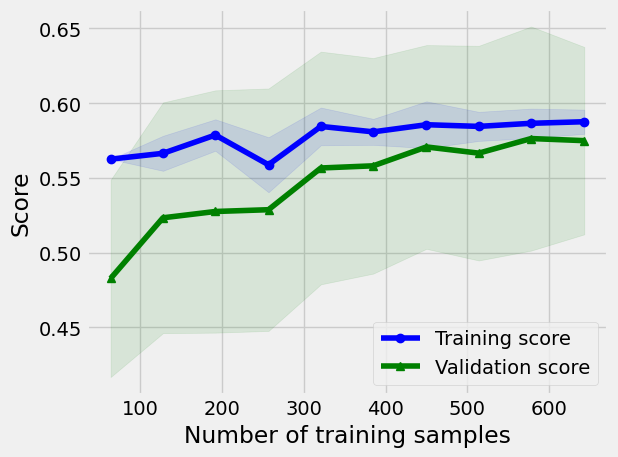

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# 繪製學習曲線
plt.plot(train_sizes, 
         train_scores_mean, 
         color='blue', 
         marker='o', 
         label='Training score')

# 填充區域 (訓練分數)
plt.fill_between(train_sizes, 
                 train_scores_mean + train_scores_std, 
                 train_scores_mean - train_scores_std, 
                 color='blue', alpha=.1)

# 繪製驗證曲線
plt.plot(train_sizes, valid_scores_mean, 
         color='green', marker='^', 
         label='Validation score')

# 填充區域 (驗證分數)
plt.fill_between(train_sizes, 
                 valid_scores_mean + valid_scores_std, 
                 valid_scores_mean - valid_scores_std, 
                 color='green', alpha=.1)

# 加入標題與軸標籤
plt.xlabel('Number of training samples')
plt.ylabel('Score')
plt.legend(loc='lower right')
plt.tight_layout()

整體而言，訓練與驗證曲線雖然漸漸收斂，可是兩者的準確率仍然偏低，疑似為欠擬合的情況，可朝增加新特徵或提升模型複雜度的方向進行調整。

## 驗證曲線 (Validation Curve)

與學習曲線類似，不同之處在於驗證曲線的橫軸是模型的各種超參數值。

通常驗證曲線用來觀察在單一超參數值設定下的訓練與驗證分數曲線，以判斷估計器 (estimator) 是否處於過擬合或欠擬合。需注意的是，若我們以驗證曲線為依據來優化超參數值，容易造成偏差而降低泛化能力。

同時挑選多個超參數值比較正確的做法是網格搜尋 (Grid Search)，透過交叉驗證來找出最佳的超參數組合。

In [40]:
from sklearn.model_selection import validation_curve

# 設定超參數的範圍
param_range = np.logspace(-4, 4, 9)
'''
[1.e-04 1.e-03 1.e-02 1.e-01 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04]

等同於
[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
'''

# 建立羅吉斯迴歸模型
clf = LogisticRegression(penalty='l1', solver='saga')

# 計算驗證曲線
train_scores, valid_scores = validation_curve(
    clf, 
    X, 
    y, 
    param_name="C", # 正規化強度，C 越小表示正規化強度越高
    param_range=param_range, # 超參數 C 的範圍
    cv=10, 
    scoring="accuracy")

# 顯示 CV 過程中，的前 5 筆訓練分數
train_scores[:5, :]

array([[0.52860697, 0.52860697, 0.52860697, 0.47014925, 0.52919255,
        0.52919255, 0.52919255, 0.52919255, 0.52919255, 0.47080745],
       [0.53109453, 0.52985075, 0.52985075, 0.53233831, 0.53167702,
        0.53043478, 0.53043478, 0.53167702, 0.53043478, 0.53167702],
       [0.53606965, 0.5261194 , 0.55597015, 0.53233831, 0.53540373,
        0.53167702, 0.53540373, 0.54534161, 0.53540373, 0.53167702],
       [0.54850746, 0.53606965, 0.55223881, 0.5460199 , 0.53416149,
        0.54409938, 0.55031056, 0.54037267, 0.54037267, 0.5242236 ],
       [0.54850746, 0.53731343, 0.54975124, 0.54850746, 0.53664596,
        0.54161491, 0.55031056, 0.54285714, 0.54037267, 0.52795031]])

In [41]:
# 計算訓練資料的平均數和標準差
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)

# 顯示驗證資料的平均數和標準差
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)

# 顯示驗證資料的平均數
valid_scores_mean

array([0.51901373, 0.53131086, 0.52463171, 0.52355805, 0.52354557,
       0.52243446, 0.52243446, 0.52243446, 0.52355805])

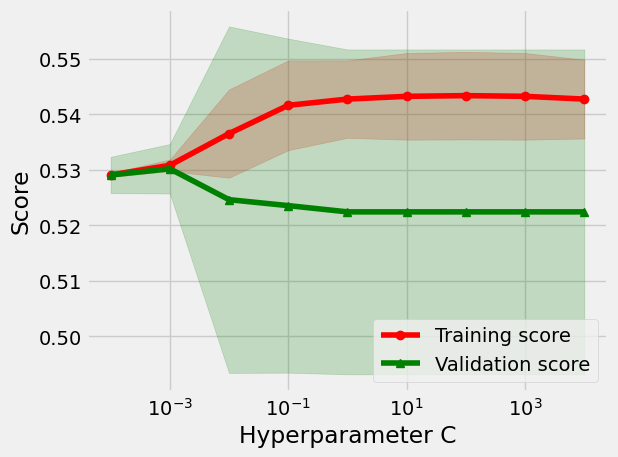

In [38]:
# 繪製驗證曲線 (訓練分數)
plt.semilogx(param_range, train_scores_mean, 
             label="Training score", color="r", 
             marker='o')

# 填充區域 (訓練分數)
plt.fill_between(param_range, 
                 train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, 
                 alpha=0.2, color="r")

# 繪製驗證曲線 (驗證分數)
plt.semilogx(param_range, valid_scores_mean, 
             label="Validation score", color="g", 
             marker='^')

# 填充區域 (驗證分數)
plt.fill_between(param_range, 
                 valid_scores_mean - valid_scores_std,
                 valid_scores_mean + valid_scores_std, 
                 alpha=0.2, color="g")

# 加入標題與軸標籤
plt.legend(loc='lower right')
plt.xlabel('Hyperparameter C')
plt.ylabel('Score')
plt.tight_layout()

## P-R 曲線

P 就是精確率 (Precision)，R 就是召回率 (Recall)，P-R 線是以橫軸為召回率且縱軸為精確度的曲線，能呈現精確度與召回率在不同門檻值下的平衡點。

P-R 曲線下方的面積越大，代表精確度與召回率的越高，模型的表現越好。

平均精確率 (Average Precision) 是 P-R 曲線下方的面積，可以用來評估模型的表現。其公式為:

$AP = \sum_{n} (R_n - R_{n-1}) \cdot P_n$

其中 $R_n$ 是召回率，$P_n$ 是精確率，$n$ 是第幾個門檻值，門檻指的是預測機率的閾值。

In [ ]:
from sklearn.metrics import average_precision_score

# 訓練模型
pipe_lr.fit(X_train, y_train)

# 計算決策分數 (用於計算 AP 值)
y_score = pipe_lr.decision_function(X_test)

# 計算 AP 值
ap = average_precision_score(y_test, y_score)

print(f'Average precision-recall score: {ap:.2f}')

Average precision-recall score: 0.73


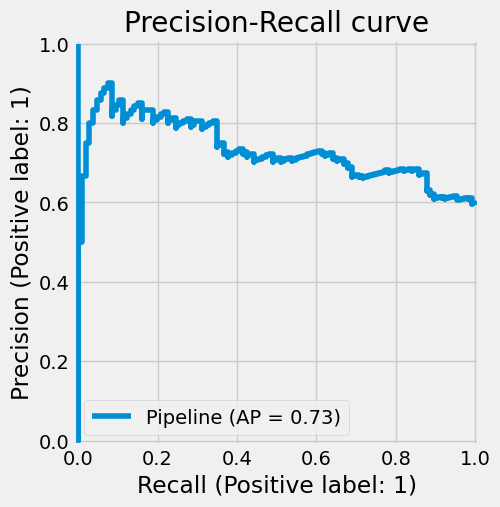

In [52]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

# 計算 Precision-Recall 曲線
disp = PrecisionRecallDisplay.from_estimator(pipe_lr, X_test, y_test)

# 顯示標題
disp.ax_.set_title('Precision-Recall curve')

# 設定圖表寬高
disp.figure_.set_size_inches(5, 5)

## ROC (Receiver Operating Characteristic) 曲線

ROC 曲線是以真陽性率 (TPR) 為縱軸，偽陽性率 (FPR) 為橫軸，畫出的曲線，用來評估二元分類器的表現。

真陽性率 (TPR) 是召回率的另一種稱呼，計算方式為:

$TPR = \frac{TP}{TP + FN}$

偽陽性率 (FPR) 的計算方式為:

$FPR = \frac{FP}{FP + TN}$

ROC 曲線越靠近左上角，AUC 曲線下面積會越大，也就代表分類決策品質越好

![](https://upload.wikimedia.org/wikipedia/commons/thumb/1/13/Roc_curve.svg/1280px-Roc_curve.svg.png)

參考資料: https://en.wikipedia.org/wiki/Receiver_operating_characteristic

## AUC (Area Under Curve) 

ROC曲線下方的面積（英語：Area under the Curve of ROC），其意義是：
- 因為是在1x1的方格裡求面積，AUC必在0~1之間。
- 假設閾值以上是陽性，以下是陰性。
- 若隨機抽取一個陽性樣本和一個陰性樣本，分類器正確判斷陽性樣本的值高於陰性樣本之機率 
${\displaystyle =AUC}$。
- 簡單說：AUC值越大的分類器，正確率越高。

從AUC判斷分類器（預測模型）優劣的標準：
- AUC = 1，是完美分類器，採用這個預測模型時，存在至少一個閾值能得出完美預測。絕大多數預測的場合，**不存在完美分類器**。
- 0.5 < AUC < 1，優於隨機猜測。這個分類器（模型）妥善設定閾值的話，能有預測價值。
- AUC = 0.5，跟隨機猜測一樣（例：丟銅板），模型沒有預測價值。
- AUC < 0.5，比隨機猜測還差；但只要總是反預測而行，就優於隨機猜測。

參考資料: https://zh.wikipedia.org/zh-tw/ROC曲线

In [64]:
from sklearn.metrics import roc_curve, auc

# 計算 ROC 曲線
fpr, tpr, _ = roc_curve(y_test, y_score)
'''
fpr = False Positive Rate
tpr = True Positive Rate
_ = Thresholds
'''

# 計算 AUC 值
roc_auc = auc(fpr, tpr)

roc_auc

np.float64(0.6672266735590592)

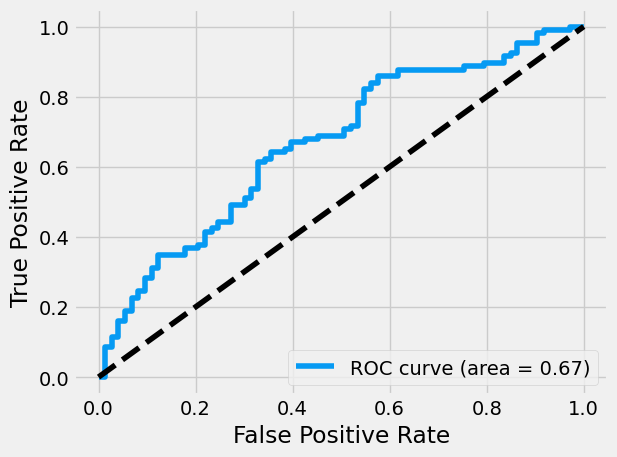

In [63]:
# 繪製 ROC 曲線
plt.plot(fpr, tpr, color='xkcd:azure', 
         label=f'ROC curve (area = {roc_auc:.2f})' )

# 繪製對角線
plt.plot([0, 1], [0, 1], color='black', linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.tight_layout()

## 調校超參數

### 讀取資料

In [67]:
import pandas as pd

# 讀取資料
df = pd.read_csv('ex4.csv')

# 增加一個欄位，標示在 Type1、Type2 中是否有 Water 屬性
type_ = 'Water'
lst1 = [1 if x == type_ else 0 for x in df.Type1]
lst2 = [1 if x == type_ else 0 for x in df.Type2]
df[type_] = [1 if lst1[i] == 1 or lst2[i] == 1 else 0 for i in range(len(lst1))]

# 列出有無 Water 屬性的數量
print(df[type_].value_counts())

# 顯示 3 筆資料 (索引)
df.take([200,300,400])

Water
0    754
1    140
Name: count, dtype: int64


,Number,Name,Type1,Type2,HP,Attack,Defense,SpecialAtk,SpecialDef,Speed,Generation,Legendary,Water
200,185,樹才怪,Rock,NaN,70,100,115,30,65,30,2,False,0
300,277,大王燕,Normal,Flying,60,85,60,50,50,125,3,False,0
400,365,帝牙海獅,Ice,Water,110,80,90,95,90,65,3,False,1


In [68]:
from sklearn.model_selection import train_test_split

# 準備訓練資料
X, y = df.loc[:, 'HP':'Speed'], df[type_]

# 切分訓練與測試資料
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2,
    random_state=0
)

# 顯示訓練與測試資料的筆數
print(X_train.shape)
print(X_test.shape)

(715, 6)
(179, 6)


### 一般測試超參數的作法 (沒那麼好)

In [ ]:
from sklearn.linear_model import LogisticRegression

# 初始化最佳分數
best_score = 0

# 以巢狀迴圈測試超參數組合
for p in ['l1', 'l2']:
    for c in [.001, .01, .1, 1, 10, 100]:
        # solver 改為 saga，同時應用到 L1, L2
        # max_iter 改為 1000，期待能盡量得到收斂結果
        logit = LogisticRegression(
            penalty=p, 
            C=c, 
            solver='saga', 
            max_iter=1000
        )

        # 訓練模型
        logit.fit(X_train, y_train)

        # 計算準確度
        score = logit.score(X_test, y_test)
        
        # 顯示超參數組合與準確度 (如果有更好的組合，則更新)
        if score > best_score:
            best_score = score
            best_param = {'penalty':p, 'C':c}

print(f'Best score: {best_score:.3f}')
print(f'Best parameters: {best_param}')

Best score: 0.866
Best parameters: {'penalty': 'l1', 'C': 0.001}


### 網格搜尋 (Grid Search)
以暴力 (brute-force) 的方式將所有可能的超參數組合都試一遍，並透過交叉驗證來找出最佳的超參數組合。

#### GridSearchCV
在 scikit-learn 中，GridSearchCV 是一種用於調整模型超參數的工具。它的主要目的是通過系統化地嘗試不同的超參數組合來找到最佳的模型配置。這對於提升模型的預測效果尤為重要，因為適當的超參數可以顯著提高模型的性能。

以下是 GridSearchCV 的工作流程與主要特點：
- 定義參數網格：首先，您需要定義模型的超參數範圍（網格），並以字典的形式傳入。每個鍵對應模型的一個超參數名稱，鍵值是一組該參數可能的值。舉例來說，若使用支持向量機（SVM）模型，可以設置如 {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']} 的參數網格。
- 交叉驗證：GridSearchCV 通常會搭配交叉驗證來評估不同參數組合的表現。在交叉驗證過程中，資料會被分成多個訓練集和測試集，並在不同的參數組合下反覆訓練與評估，以確保模型的穩定性和泛化能力。
- 網格搜尋：系統會根據您定義的參數範圍組合，逐一嘗試每一種組合，並計算每種組合在交叉驗證下的評分結果。
- 最佳參數選擇：最後，GridSearchCV 會根據所有組合的交叉驗證結果，挑選出使評分最高的參數組合。這樣，模型就能夠在該組合下達到最佳性能。
- 返回最佳模型：GridSearchCV 還會返回使用最佳參數訓練的模型，您可以直接用這個模型進行預測或其他後續操作。

In [ ]:
import numpy as np
from sklearn.model_selection import GridSearchCV

# 建立羅吉斯迴歸模型
logit = LogisticRegression(solver='saga', max_iter=1000)

# 設定超參數 (penalty)
penalty = ['l1', 'l2']

# 設定超參數: 產生 10 個 C 值
C = np.logspace(-4, 2, 10)
'''
[1.00000000e-04 4.64158883e-04 2.15443469e-03 1.00000000e-02
 4.64158883e-02 2.15443469e-01 1.00000000e+00 4.64158883e+00
 2.15443469e+01 1.00000000e+02]
'''

# 設定超參數範圍
hyper_param = dict(
    C=C, 
    penalty=penalty
)

# 進行網格搜尋
grid_s = GridSearchCV(
    logit, 
    hyper_param, 
    cv=5, 
    verbose=1
)

# 訓練模型
grid_s.fit(X_train, y_train)

print('Best score (training):', grid_s.best_score_)
print('Best parameters (training):', grid_s.best_params_)

# 顯示測試資料的準確度
grid_s.score(X_test, y_test)

[1.00000000e-04 4.64158883e-04 2.15443469e-03 1.00000000e-02
 4.64158883e-02 2.15443469e-01 1.00000000e+00 4.64158883e+00
 2.15443469e+01 1.00000000e+02]
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best score (training): 0.8377622377622378
Best parameters (training): {'C': np.float64(0.0001), 'penalty': 'l1'}


0.8659217877094972

#### 同時用多個模型來調整超參數，找出最佳模型

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline, make_pipeline

# 設定隨機種子(目的是得到相同的執行結果以做驗證)
np.random.seed(0)

# 建立管線，先標準化再建立 SVC
pipe_svc = Pipeline([('std', StandardScaler()), 
                     ('svc', SVC())])

# 建立管線 (有可能最後會被取代，視網格搜尋的結果而定)
pipe = Pipeline([('clf', RandomForestClassifier())])

# 產生候選模型與對應的超參數
param_range = np.logspace(-4, 2, 10)
param_grid = [
    {'clf': [LogisticRegression()], 
     'clf__penalty': ['l1', 'l2'], 
     'clf__C': param_range}, 
    {'clf': [RandomForestClassifier()], 
     'clf__n_estimators': [10, 100, 300, 500],
     'clf__max_depth': [3, 4, 5],
     'clf__max_features': [2, 3, 4]}, 
    {'clf': [pipe_svc], 
     'clf__svc__C': param_range, 
     'clf__svc__kernel': ['linear']},
    {'clf': [pipe_svc], 
     'clf__svc__C': param_range, 
     'clf__svc__gamma': param_range, 
     'clf__svc__kernel': ['rbf']}
]

# 進行網格搜尋 (grid_s 有可能會被換成其他模型，視網格搜尋的結果而定)
grid_s = GridSearchCV(
    estimator=pipe, 
    param_grid=param_grid, 
    scoring='accuracy', 
    cv=5, 
    verbose=1,
    n_jobs=-1
)
'''
grid_s 最終得到的最佳模型取決於哪一組模型和參數能在交叉驗證中達到最佳結果。
因此，它不會被限制為隨機森林分類器，
而是可以是 param_grid 中定義的任何模型（LogisticRegression、RandomForestClassifier 或 SVC），
具體取決於搜尋過程的結果。
'''

# 訓練模型
grid_s.fit(X_train, y_train)

# 顯示最佳分數與超參數
print('Best score (training):', grid_s.best_score_)
print('Best parameters (training):', grid_s.best_params_)
grid_s.score(X_test, y_test)

Fitting 5 folds for each of 166 candidates, totalling 830 fits
Best score (training): 0.8391608391608392
Best parameters (training): {'clf': RandomForestClassifier(), 'clf__max_depth': 4, 'clf__max_features': 3, 'clf__n_estimators': 100}


0.8659217877094972

#### RandomizedSearchCV

在 scikit-learn 中，RandomizedSearchCV 是一種超參數調整的工具，用於在指定的超參數範圍內隨機選取組合並進行評估。這與另一種常用的方法 GridSearchCV 不同，後者會遍歷每一個超參數的所有可能組合，而 RandomizedSearchCV 僅隨機選取固定次數的超參數組合，因此可以在較少的計算資源下達到較好的結果。

RandomizedSearchCV 的流程
- 設定超參數範圍：我們定義模型超參數的範圍，例如樹的深度或學習率。每個超參數都可以設置為一個分佈（如均勻分佈、正態分佈等）或一組可能的取值。
- 隨機選擇組合：RandomizedSearchCV 會從這些範圍內隨機選取多組超參數組合，然後根據這些組合進行模型訓練。
- 交叉驗證：對於每一組隨機選出的超參數組合，RandomizedSearchCV 使用交叉驗證來評估模型表現。
- 最佳參數選擇：在所有組合中，RandomizedSearchCV 選擇效果最好的超參數組合，作為最終模型的最佳超參數。

RandomizedSearchCV 的優點
- 計算效率高：相比於遍歷所有組合的 Grid Search，隨機搜索在計算時間上更有效率，尤其在參數空間很大時特別有用。
- 可能找到全域最佳解：在一定的搜索次數下，隨機選擇可以覆蓋參數空間的較大範圍，有時甚至能比 Grid Search 更快地找到理想的超參數。
- 靈活性：可以使用連續的分佈進行搜索（如均勻分佈或正態分佈），而不僅僅是離散的固定值。


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, norm

# 建立羅吉斯迴歸模型
logit = LogisticRegression(
    solver='saga', 
    max_iter=1000, 
    random_state=0
)

# 產生均勻分布的樣本點
dist = dict(
    C=uniform(loc=0, scale=0.01).rvs(100), 
    penalty=['l2', 'l1']
)



# 隨機搜尋
clf = RandomizedSearchCV(
    logit,
    dist, 
    random_state=0, 
    verbose=1,
    n_jobs=-1
)

# 訓練模型
rand_s = clf.fit(X_train, y_train)

# 顯示最佳分數與超參數
print('Best score (training):', rand_s.best_score_)
print('Best parameters (training):', rand_s.best_params_)
rand_s.score(X_test, y_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best score (training): 0.8377622377622378
Best parameters (training): {'penalty': 'l2', 'C': np.float64(0.002832609637559108)}


0.8659217877094972

#### 考慮模型特性來調整超參數

In [75]:
# 有些模型會有 xxxCV 類別，可以自動調整超參數
from sklearn.linear_model import LogisticRegressionCV

# 建立羅吉斯迴歸模型
logit = LogisticRegressionCV(
    Cs=100, # 在 1e-4 and 1e4 之間產生 100 個 C 值，類似 np.logspace(-4, 4, 100)
    cv=10, 
    random_state=0
)

# 訓練模型
logit.fit(X_train, y_train)

# 顯示最佳超參數
print('Best C:', logit.C_)

# 顯示測試資料的準確度
logit.score(X_test, y_test)

Best C: [0.0001]


0.8659217877094972

#### 巢狀交叉驗證 (Nested Cross-Validation)

意思是在交叉驗證的基礎上再套用一層交叉驗證，用來評估模型的泛化能力。外層交叉驗證用來評估模型的性能，內層交叉驗證則用來選擇最佳的超參數組合。這樣做的好處是可以更好地估計模型的泛化能力，避免過度擬合。

In [76]:
from sklearn.model_selection import cross_val_score

# 建立網格搜尋
grid_s = GridSearchCV(
    estimator=pipe, 
    param_grid=param_grid, 
    cv=2, 
    scoring='accuracy', 
    n_jobs=-1, 
    verbose=1
)

# 進行巢狀交叉驗證
scores = cross_val_score(
    grid_s, 
    X_train, 
    y_train, 
    scoring='accuracy', 
    cv=3
)

print(f'CV accuracy (training): {np.mean(scores):.3f} +/- {np.std(scores):.3f}')

# 訓練模型
grid_s.fit(X_train, y_train)

print('Best parameters (training):', grid_s.best_params_)

# 顯示測試資料的準確度
grid_s.score(X_test, y_test)

Fitting 2 folds for each of 166 candidates, totalling 332 fits
Fitting 2 folds for each of 166 candidates, totalling 332 fits
Fitting 2 folds for each of 166 candidates, totalling 332 fits
CV accuracy (training): 0.838 +/- 0.002
Fitting 2 folds for each of 166 candidates, totalling 332 fits
Best parameters (training): {'clf': Pipeline(steps=[('std', StandardScaler()), ('svc', SVC())]), 'clf__svc__C': np.float64(1.0), 'clf__svc__gamma': np.float64(4.641588833612772), 'clf__svc__kernel': 'rbf'}


0.8659217877094972

#### 以評估指標為依據來調整超參數

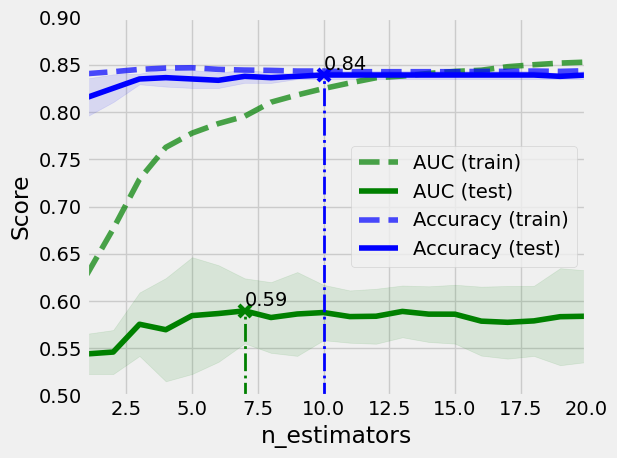

In [ ]:
from matplotlib import pyplot as plt
plt.style.use('fivethirtyeight')
from sklearn.metrics import make_scorer, accuracy_score

# 套用兩個評分指標到網格搜尋
scoring = {'AUC': 'roc_auc', 
           'Accuracy': make_scorer(accuracy_score)}

# 設定超參數範圍
d = {
    'n_estimators': range(1, 21), 
    'max_depth': [4], 
    'max_features': [4]
}

# 進行網格搜尋
gs = GridSearchCV(
    RandomForestClassifier(random_state=0),
    param_grid=d,
    scoring=scoring, 
    refit='AUC', 
    return_train_score=True, 
    n_jobs=-1
)

# 訓練模型
gs.fit(X_train, y_train)

# 取得網格搜尋的結果 (以下結果很多要參考這個變數 results)
results = gs.cv_results_

# 取出決策樹數量作為 x 軸
X_axis = np.array(results['param_n_estimators'].data, dtype=float)

# 設定 x, y 軸刻度範圍
ax = plt.gca()
ax.set_xlim(1, 20)
ax.set_ylim(0.5, 0.9)

# 繪製 AUC 與 Accuracy 曲線
for scorer, color in zip(sorted(scoring), ['g', 'b']):
    for sample, style in (('train', '--'), ('test', '-')):
        # 取出不同評分指標的平均值與標準差
        sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
        sample_score_std = results['std_%s_%s' % (sample, scorer)]

        # 繪製分數標準差區間 (背景顏色淡淡的部分)
        ax.fill_between(X_axis, 
                        sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == 'test' else 0, color=color)
        
        # 繪製分數平均值
        ax.plot(X_axis, sample_score_mean, style, color=color,
                alpha=1 if sample == 'test' else 0.7,
                label=f"{scorer} ({sample})")
        
    
    # 取出 test 的最佳索引值與分數
    best_index = np.nonzero(results[f'rank_test_{scorer}'] == 1)[0][0]
    best_score = results[f'mean_test_{scorer}'][best_index]

    # 畫出最佳分數的位置
    ax.plot(
        [X_axis[best_index], ] * 2, 
        [0, best_score], 
        lw=2,
        linestyle='-.', 
        color=color, 
        marker='x', 
        markeredgewidth=3, 
        ms=8
    )

    # 標示最大值的分數
    ax.annotate(
        f"{best_score:.2f}",
        (X_axis[best_index], 
         best_score + 0.005)
    )

plt.xlabel('n_estimators')
plt.ylabel('Score')
plt.legend()
plt.tight_layout()

### 處理類別不平衡

In [83]:
# 增加一個欄位，標示在 Type1、Type2 中是否有 Water 屬性
type_ = 'Fire'
lst1 = [1 if x == type_ else 0 for x in df.Type1]
lst2 = [1 if x == type_ else 0 for x in df.Type2]
df[type_] = [1 if lst1[i] == 1 or lst2[i] == 1 else 0 for i in range(len(lst1))]

# 列出有無 Fire 屬性的數量
print(df[type_].value_counts())

# 顯示 3 筆資料 (索引)
df.take([170,270,370])

Fire
0    822
1     72
Name: count, dtype: int64


,Number,Name,Type1,Type2,HP,Attack,Defense,SpecialAtk,SpecialDef,Speed,Generation,Legendary,Water,Fire
170,156,火岩鼠,Fire,NaN,58,64,58,80,65,80,2,False,0,1
270,250,鳳王,Fire,Flying,106,130,90,110,154,90,2,True,0,1
370,338,太陽岩,Rock,Psychic,70,95,85,55,65,70,3,False,0,0


In [85]:
# 準備訓練資料
X, y = df.loc[:, 'HP':'Speed'], df[type_]

# 切分訓練與測試資料
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2,
    random_state=0
)

# 顯示訓練與測試資料的筆數
print('訓練資料切分結果:')
print(y_train.value_counts())
print('測試資料切分結果:')
print(y_test.value_counts())

訓練資料切分結果:
Fire
0    663
1     52
Name: count, dtype: int64
測試資料切分結果:
Fire
0    159
1     20
Name: count, dtype: int64


In [86]:
from sklearn.metrics import classification_report

# 建立管線
pipe = Pipeline([('clf', RandomForestClassifier())])

# 設定超參數範圍
param_range = np.logspace(-4, 2, 10)

# 設定網格搜尋的超參數範圍
param_grid = [{'clf': [LogisticRegression()], 
               'clf__penalty': ['l1', 'l2'], 
               'clf__C': param_range}, 
              {'clf': [RandomForestClassifier()], 
               'clf__n_estimators': [10, 20, 30, 50],
               'clf__max_depth': [3, 4, 5],
               'clf__max_features': [2, 3, 4]}]

# 評估指標為 accuracy
grid_s = GridSearchCV(
    estimator=pipe, 
    cv=2, 
    param_grid=param_grid, 
    scoring='accuracy',
    n_jobs=-1
)

# 進行交叉驗證
scores = cross_val_score(
    grid_s, 
    X_train, 
    y_train, 
    scoring='accuracy', 
    cv=3
)


# 顯示交叉驗證的分數
print(f'CV score (training): {np.mean(scores):.3f} +/- {np.std(scores):.3f}')

# 訓練模型
grid_s.fit(X_train, y_train)

# 顯示最佳分數與超參數
print('Best parameters (training):', grid_s.best_params_)

# 預測測試資料
y_pred = grid_s.predict(X_test)

# 顯示分類報告
print(classification_report(y_pred, y_test))

CV score (training): 0.926 +/- 0.002
Best parameters (training): {'clf': RandomForestClassifier(), 'clf__max_depth': 5, 'clf__max_features': 3, 'clf__n_estimators': 50}
              precision    recall  f1-score   support

           0       1.00      0.89      0.94       179
           1       0.00      0.00      0.00         0

    accuracy                           0.89       179
   macro avg       0.50      0.44      0.47       179
weighted avg       1.00      0.89      0.94       179



#### 加入 class_weight 參數

class_weight 參數是用來調整不同類別的權重，以解決類別不平衡的問題。在訓練模型時，我們可以通過設置此參數來調整不同類別的權重，使得模型更加關注少數類別，從而提高模型對少數類別的預測能力。

In [88]:
from sklearn.metrics import classification_report

# 建立管線
pipe = Pipeline([('clf', RandomForestClassifier())])

# 設定超參數範圍
param_range = np.logspace(-4, 2, 10)


# 加入 class_weight 參數
param_grid = [{'clf': [LogisticRegression()], 
               'clf__penalty': ['l1', 'l2'], 
               'clf__C': param_range, 
               'clf__class_weight': ['balanced']}, 
              {'clf': [RandomForestClassifier()], 
               'clf__n_estimators': [10, 20, 30, 50],
               'clf__max_depth': [3, 4, 5],
               'clf__max_features': [2, 3, 4], 
               'clf__class_weight': ['balanced']}]

# 評估指標為 recall
grid_s = GridSearchCV(
    estimator=pipe, 
    cv=2, 
    param_grid=param_grid, 
    scoring='recall',
    n_jobs=-1
)

# 進行交叉驗證
scores = cross_val_score(
    grid_s, 
    X_train, 
    y_train, 
    scoring='recall', 
    cv=3
)

# 顯示交叉驗證的分數
print(f'CV score (training): {np.mean(scores):.3f} +/- {np.std(scores):.3f}')

# 訓練模型
grid_s.fit(X_train, y_train)

# 顯示最佳分數與超參數
print('Best parameters (training):', grid_s.best_params_)

# 預測測試資料
y_pred = grid_s.predict(X_test)

# 顯示分類報告
print(classification_report(y_pred, y_test))

CV score (training): 0.709 +/- 0.088
Best parameters (training): {'clf': LogisticRegression(), 'clf__C': np.float64(0.0001), 'clf__class_weight': 'balanced', 'clf__penalty': 'l2'}
              precision    recall  f1-score   support

           0       0.62      0.93      0.75       106
           1       0.65      0.18      0.28        73

    accuracy                           0.63       179
   macro avg       0.64      0.56      0.51       179
weighted avg       0.63      0.63      0.56       179



### 回放式抽樣 (Resampling)

回放式抽樣是一種用於處理類別不平衡的方法，**對少數量類別放回式重複取樣** (不會造成虛假資料)，使得少數類別的樣本數與多數類別相同。這樣可以平衡類別分佈，提高模型對少數類別的預測能力。

常用於 upsampling (上採樣，增加訓練數據) 與 downsampling (下採樣，減少訓練數據)。

In [98]:
from sklearn.utils import resample

# 顯示訓練資料的筆數
print(y_train.value_counts())

# 對類別 1 進行放回式取樣
size = y_train[y_train == 0].shape[0]
'''
size=663
'''

# 進行放回式取樣
X_up, y_up = resample(
    X_train[y_train == 1], # 52 筆資料
    y_train[y_train == 1], # 52 筆資料
    replace=True, # 放回式取樣
    n_samples=size, # 取樣筆數
    random_state=0
)

# 顯示放回式取樣後的筆數
X_train_up = np.vstack((X_train[y_train==0], X_up))

# 顯示放回式取樣後的筆數
y_train_up = np.hstack((y_train[y_train==0], y_up))

# 顯示放回式取樣後的筆數
print('Class 0:', len(y_train_up) - y_train_up.sum())
print('Class 1:', y_train_up.sum())

Fire
0    663
1     52
Name: count, dtype: int64
Class 0: 663
Class 1: 663


In [99]:
# 邏輯斯迴歸擬合類別不平衡數據
logit = LogisticRegression()
logit = logit.fit(X_train, y_train)

# 預測測試資料
y_pred = logit.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       1.00      0.89      0.94       179
           1       0.00      0.00      0.00         0

    accuracy                           0.89       179
   macro avg       0.50      0.44      0.47       179
weighted avg       1.00      0.89      0.94       179



In [100]:
# 邏輯斯迴歸加上 class_weight='balanced'
logit = LogisticRegression(class_weight='balanced')

# 訓練模型
logit.fit(X_train, y_train)

# 預測測試資料
y_pred = logit.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.64      0.94      0.76       109
           1       0.65      0.19      0.29        70

    accuracy                           0.64       179
   macro avg       0.65      0.56      0.53       179
weighted avg       0.64      0.64      0.58       179



In [101]:
# 邏輯斯迴歸擬合經過上取樣的數據
logit = LogisticRegression()

# 訓練模型
logit.fit(X_train_up, y_train_up)

# 預測測試資料
y_pred = logit.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.65      0.94      0.77       111
           1       0.65      0.19      0.30        68

    accuracy                           0.65       179
   macro avg       0.65      0.56      0.53       179
weighted avg       0.65      0.65      0.59       179

